In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import *
import numpy as np
#import peakutils

In [2]:
#bring in the summary table 
#format the date time inorder to merge with data files
summary_df = pd.read_csv("Data/3MTestingLog.csv")
summary_df = summary_df.drop(['Table Name'], axis=1)
summary_df["Install Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Install Time'], format="%m/%d/%y %H:%M")
summary_df["Removal Date Time"] = pd.to_datetime(summary_df['Date'] + ' ' + summary_df['Removal Time'], format="%m/%d/%y %H:%M")

#fix the dates for when the sample was removed the following day after installation.
for i in range(len(summary_df['Date'])):
    if summary_df['Removal Date Time'][i] < summary_df['Install Date Time'][i]:
        summary_df['Removal Date Time'][i] = summary_df['Removal Date Time'][i] + timedelta(days=1)

summary_df

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,Filter ID,Install Time,Removal Time,Indoor Temp,Outdoor Temp,Outdoor RH,Pre 20x20x1,Post 20x20x1,Pre 14x24x1,Post 14x24x1,DAQ File,Install Date Time,Removal Date Time
0,11/20/19,FG-1,13:47,16:12,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 13:47:00,2019-11-20 16:12:00
1,11/20/19,FG-2,16:16,6:13,72,95,50,NaN,NaN,NaN,NaN,Data-20191120134426,2019-11-20 16:16:00,2019-11-21 06:13:00
2,11/21/19,MERV 8-1,8:02,10:18,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 08:02:00,2019-11-21 10:18:00
3,11/21/19,MERV 8-2,10:18,12:38,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 10:18:00,2019-11-21 12:38:00
4,11/21/19,1900-1,12:38,14:46,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 12:38:00,2019-11-21 14:46:00
5,11/21/19,1900-2,14:46,16:58,72,95,50,NaN,NaN,NaN,NaN,"Data-20191121080221.dld.0000,1",2019-11-21 14:46:00,2019-11-21 16:58:00
6,11/21/19,MERV 8-4,16:58,5:30,72,95,50,7.1 oz.,7.1 oz.,7.5 oz.,7.5 oz.,"Data-20191121080221.dld.0000,1",2019-11-21 16:58:00,2019-11-22 05:30:00
7,11/22/19,MERV 8-5,7:51,10:04,72,95,50,7.2 oz.,7.25 oz.,7.55 oz.,7.55 oz.,Data-20191122074415,2019-11-22 07:51:00,2019-11-22 10:04:00
8,11/22/19,1900-4,10:04,13:00,72,95,50,8.55 oz.,8.55 oz.,8 oz.,7.55 oz.,Data-20191122074415,2019-11-22 10:04:00,2019-11-22 13:00:00
9,11/22/19,1900-5,13:00,15:32,72,95,50,8.6 oz.,8.6 oz.,8.05 oz.,8.05 oz.,Data-20191122074415,2019-11-22 13:00:00,2019-11-22 15:32:00


In [3]:
summary_df.dtypes

Date                         object
Filter ID                    object
Install Time                 object
Removal Time                 object
Indoor Temp                   int64
Outdoor Temp                  int64
Outdoor RH                    int64
Pre 20x20x1                  object
Post 20x20x1                 object
Pre 14x24x1                  object
Post 14x24x1                 object
DAQ File                     object
Install Date Time    datetime64[ns]
Removal Date Time    datetime64[ns]
dtype: object

In [4]:
#Bring in the testing data except for the first file
datafiles = ["Data/Data-20191121080221_0.csv", "Data/Data-20191121080221_1.csv", 
             "Data/Data-20191122074415.csv", "Data/Data-20191125071926_0.csv", "Data/Data-20191125071926_1.csv", 
             "Data/Data-20191126061705_0.csv", "Data/Data-20191126061705_1.csv", "Data/Data-20191127053638.csv"
            ]

usecols = ['Date', 'Time', "Volts", 'Volts.1', 'Amps', 'Amps.1', 'Volts.2', 'Volts.3', 'Amps.2', 'Amps.3']

In [5]:
#pullin the first file as a dataframe, pull the desired columns and drop the first row since there are two header rows
Data1_df = pd.read_csv("Data/Data-20191120134426.csv", skiprows=1, usecols=usecols) 
#Data1_df = pd.read_csv("Data/Data-20191120134426.csv", skiprows=1)

#remove all of the rows with zeros
AllData_df = Data1_df.loc[(Data1_df['Volts']!=0)]

AllData_df

/Users/abby/miniconda3/envs/PythonData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Volts,Volts.1,Amps,Amps.1,Volts.2,Volts.3,Amps.2,Amps.3
0,2019/11/20,13:44:26,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10
1,2019/11/20,13:44:27,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10
2,2019/11/20,13:44:28,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10
3,2019/11/20,13:44:29,121.9,121.8,3.8,4.35,122.0,121.9,0.01,0.10
4,2019/11/20,13:44:30,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10
...,...,...,...,...,...,...,...,...,...,...
58979,2019/11/21,06:07:25,120.6,120.5,17.6,18.05,120.3,120.2,12.23,1.74
58980,2019/11/21,06:07:26,120.7,120.5,17.5,18.04,120.3,120.3,12.22,1.74
58981,2019/11/21,06:07:27,120.7,120.5,17.6,18.05,120.3,120.3,12.22,1.74
58982,2019/11/21,06:07:28,120.7,120.5,17.5,18.04,120.4,120.3,12.21,1.74


In [6]:
AllData_df.dtypes

Date        object
Time        object
Volts      float64
Volts.1    float64
Amps       float64
Amps.1     float64
Volts.2    float64
Volts.3    float64
Amps.2     float64
Amps.3     float64
dtype: object

In [7]:
#pull in all of the other data files and create one large file while removing all zero values
for file in datafiles:
    Data2_df = pd.read_csv(file, skiprows=1, usecols=usecols)

    #NonZeroData2_df = Data2_df[(Data2_df != 0).all(1)]
    #df.loc[~(df==0).all(axis=1)]
    NonZeroData2_df = Data2_df.loc[(Data2_df['Volts']!=0)]
        
    AllData_df = AllData_df.append(NonZeroData2_df, ignore_index=True)
    
AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")

AllData_df.shape

(357325, 11)

In [8]:
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'], format="%Y/%m/%d %H:%M:%S")
#AllData_df['Date and Time'] = pd.to_datetime(AllData_df['Date'] + ' ' + AllData_df['Time'])

ZeroData_df = AllData_df.loc[AllData_df['Volts'] == 0]

ZeroData_df.shape

(0, 11)

In [9]:
#calculating Watts column as Volts+Volts.1 * Amps+Amps.1

CalculatedColumns_df = AllData_df.copy()
CalculatedColumns_df['Whole Home Power (kW)'] = ((CalculatedColumns_df['Volts']+CalculatedColumns_df['Volts.1']) * (CalculatedColumns_df['Amps']+CalculatedColumns_df['Amps.1']))/1000
CalculatedColumns_df['Compressor Power (kW)'] = ((CalculatedColumns_df['Volts.2']+CalculatedColumns_df['Volts.3']) * CalculatedColumns_df['Amps.2'])/1000
CalculatedColumns_df['Blower Fan Power (kW)'] = (CalculatedColumns_df['Amps.3'])*120/1000
CalculatedColumns_df['Compressor and Fan Power (kW)'] = CalculatedColumns_df['Compressor Power (kW)'] + CalculatedColumns_df['Blower Fan Power (kW)']
CalculatedColumns_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Volts.2,Volts.3,Amps.2,Amps.3,Date and Time,Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW)
0,2019/11/20,13:44:26,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,2019-11-20 13:44:26,1.985340,0.002439,0.0120,0.014439
1,2019/11/20,13:44:27,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,2019-11-20 13:44:27,1.985340,0.002439,0.0120,0.014439
2,2019/11/20,13:44:28,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,2019-11-20 13:44:28,1.985340,0.002439,0.0120,0.014439
3,2019/11/20,13:44:29,121.9,121.8,3.8,4.35,122.0,121.9,0.01,0.10,2019-11-20 13:44:29,1.986155,0.002439,0.0120,0.014439
4,2019/11/20,13:44:30,121.9,121.7,3.8,4.35,122.0,121.9,0.01,0.10,2019-11-20 13:44:30,1.985340,0.002439,0.0120,0.014439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357320,2019/11/27,12:50:12,121.8,121.7,13.1,12.28,121.5,121.4,10.20,1.74,2019-11-27 12:50:12,6.180030,2.477580,0.2088,2.686380
357321,2019/11/27,12:50:13,121.9,121.8,13.1,12.31,121.6,121.4,10.22,1.75,2019-11-27 12:50:13,6.192417,2.483460,0.2100,2.693460
357322,2019/11/27,12:50:14,121.9,121.8,13.2,12.32,121.6,121.4,10.23,1.74,2019-11-27 12:50:14,6.219224,2.485890,0.2088,2.694690
357323,2019/11/27,12:50:15,121.9,121.8,13.2,12.33,121.6,121.4,10.25,1.74,2019-11-27 12:50:15,6.221661,2.490750,0.2088,2.699550


In [10]:
#create new columns in AllData_df by using conditional (mask) and data from summary_df
#with using the combined column date and time

for i in range(len(summary_df['Filter ID'])):
    mask = (CalculatedColumns_df['Date and Time'] >= summary_df['Install Date Time'][i]) & (CalculatedColumns_df['Date and Time'] <= summary_df['Removal Date Time'][i])

    #based on the summary table, what was the filter ID during this time fame
    CalculatedColumns_df.loc[mask, 'Filter ID'] = summary_df['Filter ID'][i]
    
    #based on the summary table was the outside of the home during heating or cooling season during this time fame
    CalculatedColumns_df.loc[mask, 'Outdoor Temp'] = summary_df['Outdoor Temp'][i]
    
    #based on the summary table is the filter dirty or clean during this time fame
    if (summary_df['Filter ID'][i]=='MERV 8-4') | (summary_df['Filter ID'][i]=='MERV 8-5') | (summary_df['Filter ID'][i]=='1900-4') | (summary_df['Filter ID'][i]=='1900-5'):
        CalculatedColumns_df.loc[mask, 'Clean/Dirty'] = 'Dirty'
    else:
        CalculatedColumns_df.loc[mask, 'Clean/Dirty'] = 'Clean'
        
    #added a rolling count of seconds the filter was tested for during this time fame
    CalculatedColumns_df.loc[mask, 'Cumulative Time in Test (sec)'] = CalculatedColumns_df.loc[mask, 'Filter ID'].rolling(len(CalculatedColumns_df.loc[mask, 'Filter ID'])).count()

#remove the na's. This will be the time between the tests
FilteredData_df = CalculatedColumns_df.dropna()
FilteredData_df

,Date,Time,Volts,Volts.1,Amps,Amps.1,Volts.2,Volts.3,Amps.2,Amps.3,Date and Time,Whole Home Power (kW),Compressor Power (kW),Blower Fan Power (kW),Compressor and Fan Power (kW),Filter ID,Outdoor Temp,Clean/Dirty,Cumulative Time in Test (sec)
154,2019/11/20,13:47:00,121.7,121.6,3.8,4.35,121.8,121.7,0.01,0.10,2019-11-20 13:47:00,1.982895,0.002435,0.0120,0.014435,FG-1,95.0,Clean,1.0
155,2019/11/20,13:47:01,121.7,121.5,3.8,4.35,121.8,121.7,0.00,0.10,2019-11-20 13:47:01,1.982080,0.000000,0.0120,0.012000,FG-1,95.0,Clean,2.0
156,2019/11/20,13:47:02,121.6,121.5,3.8,4.35,121.8,121.7,0.01,0.10,2019-11-20 13:47:02,1.981265,0.002435,0.0120,0.014435,FG-1,95.0,Clean,3.0
157,2019/11/20,13:47:03,121.6,121.5,3.8,4.35,121.7,121.6,0.00,0.10,2019-11-20 13:47:03,1.981265,0.000000,0.0120,0.012000,FG-1,95.0,Clean,4.0
158,2019/11/20,13:47:04,121.6,121.5,3.8,4.35,121.8,121.7,0.00,0.10,2019-11-20 13:47:04,1.981265,0.000000,0.0120,0.012000,FG-1,95.0,Clean,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357304,2019/11/27,12:49:56,121.9,121.8,12.5,11.65,121.6,121.4,9.59,1.74,2019-11-27 12:49:56,5.885355,2.330370,0.2088,2.539170,1900-5,40.0,Dirty,14217.0
357305,2019/11/27,12:49:57,121.9,121.8,12.5,11.71,121.6,121.4,9.65,1.74,2019-11-27 12:49:57,5.899977,2.344950,0.2088,2.553750,1900-5,40.0,Dirty,14218.0
357306,2019/11/27,12:49:58,121.9,121.8,12.6,11.77,121.6,121.4,9.70,1.74,2019-11-27 12:49:58,5.938969,2.357100,0.2088,2.565900,1900-5,40.0,Dirty,14219.0
357307,2019/11/27,12:49:59,121.9,121.8,12.6,11.81,121.6,121.4,9.75,1.74,2019-11-27 12:49:59,5.948717,2.369250,0.2088,2.578050,1900-5,40.0,Dirty,14220.0


In [27]:
#Gathering Energy consumed by using groupby()
#Group the data for only the first 2 hours the filter was tested
second_cut_off = 7200
Grouped_df = FilteredData_df[FilteredData_df['Cumulative Time in Test (sec)'] <= second_cut_off].groupby(['Outdoor Temp','Clean/Dirty','Filter ID'])

#Calculate the Energy     
Energy_Consumped_df = pd.DataFrame((Grouped_df['Whole Home Power (kW)'].sum())*(second_cut_off/3600))
Energy_Consumped_df = Energy_Consumped_df.rename(columns={'Whole Home Power (kW)': 'Whole Home Energy (kWh)'})

Energy_Consumped_df['Compressor Energy (kWh)'] = (Grouped_df['Compressor Power (kW)'].sum())*(second_cut_off/3600)

Energy_Consumped_df['Blower Fan Energy (kWh)'] = (Grouped_df['Blower Fan Power (kW)'].sum())*(second_cut_off/3600)

Energy_Consumped_df['Compressor and Fan Energy (kWh)'] = (Grouped_df['Compressor and Fan Power (kW)'].sum())*(second_cut_off/3600)

Energy_Consumped_df

Whole Home Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                54229.553674   
                         1900-2                53212.072070   
                         FG-1                  45432.179332   
                         FG-2                  51318.640382   
                         MERV 8-1              53485.846738   
                         MERV 8-2              51673.764128   
             Dirty       1900-4                54550.248538   
                         1900-5                51122.188168   
                         MERV 8-4              52656.316570   
                         MERV 8-5              53721.515276   
95.0         Clean       1900-1                76275.949518   
                         1900-2                71478.759040   
                         FG-1                  75981.922686   
                         FG-2                  75130.742794   
                         MERV 8-1              72422.651190   
                         MERV 8-2              73481.702654   
             Dirty       1900-4                72700.785334   
                         1900-5                76048.627160   
                         MERV 8-4              73701.586384   
                         MERV 8-5              72109.794748   

                                    Compressor Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                17448.949520   
                         1900-2                16945.960206   
                         FG-1                  16788.341084   
                         FG-2                  16164.289860   
                         MERV 8-1              17175.175040   
                         MERV 8-2              16557.412658   
             Dirty       1900-4                17570.514486   
                         1900-5                16967.633920   
                         MERV 8-4              16935.083220   
                         MERV 8-5              17309.720770   
95.0         Clean       1900-1                20894.175516   
                         1900-2                18744.966726   
                         FG-1                  20783.941744   
                         FG-2                  20470.087482   
                         MERV 8-1              19120.260538   
                         MERV 8-2              19679.496422   
             Dirty       1900-4                19251.516740   
                         1900-5                20680.189422   
                         MERV 8-4              19683.012000   
                         MERV 8-5              19000.431198   

                                    Blower Fan Energy (kWh)  \
Outdoor Temp Clean/Dirty Filter ID                            
40.0         Clean       1900-1                   1612.9584   
                         1900-2                   1577.3808   
                         FG-1                     1524.9480   
                         FG-2                     1498.4712   
                         MERV 8-1                 1583.4672   
                         MERV 8-2                 1499.2320   
             Dirty       1900-4                   1649.4216   
                         1900-5                   1549.2120   
                         MERV 8-4                 1603.5288   
                         MERV 8-5                 1579.8168   
95.0         Clean       1900-1                   1782.4008   
                         1900-2                   1636.0224   
                         FG-1                     1717.0584   
                         FG-2                     1702.0776   
                         MERV 8-1                 1699.1352   
                         MERV 8-2                 1713.2952   
             Dirty       1900-4                   1693.0920   
                         1900-5                   1783.7424   
  

In [31]:
#create a new group with just values during the heating season
heating_group = FilteredData_df[FilteredData_df['Outdoor Temp'] == 40.0].groupby(['Clean/Dirty', 'Filter ID'])
heating_group.sum()

Volts       Volts.1      Amps     Amps.1  \
Clean/Dirty Filter ID                                                 
Clean       1900-1     1437438.3  1.436283e+06   90545.4   80389.14   
            1900-2     1457947.5  1.456778e+06   90228.9   80025.17   
            FG-1       1032460.9  1.031633e+06   59405.0   52150.65   
            FG-2       1771540.4  1.770128e+06  105685.8   93247.93   
            MERV 8-1   1749084.4  1.747685e+06  108143.1   95919.26   
            MERV 8-2   5546413.3  5.541953e+06  340271.6  301364.55   
Dirty       1900-4     1412501.7  1.411344e+06   89935.4   80033.06   
            1900-5     1727429.9  1.726023e+06  100239.6   87775.33   
            MERV 8-4   1641257.9  1.639935e+06  100653.6   89214.96   
            MERV 8-5   5629661.7  5.625145e+06  346086.7  306553.81   

                         Volts.2       Volts.3     Amps.2    Amps.3  \
Clean/Dirty Filter ID                                                 
Clean       1900-1     1435766.8  1.433905e+06   57666.65  10863.45   
            1900-2     1456293.2  1.454411e+06   57353.03  10725.85   
            FG-1       1031328.6  1.029959e+06   41398.10   7573.00   
            FG-2       1769682.8  1.767344e+06   67685.48  12576.03   
            MERV 8-1   1747050.2  1.744769e+06   70277.61  13086.56   
            MERV 8-2   5540043.4  5.532869e+06  219926.59  40468.74   
Dirty       1900-4     1410873.4  1.409068e+06   57511.65  10870.66   
            1900-5     1725683.1  1.723446e+06   64831.46  12111.20   
            MERV 8-4   1639360.7  1.637242e+06   65276.79  12219.46   
            MERV 8-5   5623134.3  5.615845e+06  225079.41  42166.21   

                       Whole Home Power (kW)  Compressor Power (kW)  \
Clean/Dirty Filter ID                                                 
Clean       1900-1              41302.883738           13893.153455   
            1900-2              41322.767549           13875.930963   
            FG-1                27013.950034            9991.838286   
            FG-2                48275.955462           16376.465100   
            MERV 8-1            49702.358985           17062.585827   
            MERV 8-2           156134.500112           53344.969720   
Dirty       1900-4              41217.683447           13900.770731   
            1900-5              45615.916108           15682.621279   
            MERV 8-4            46331.554269           15875.620844   
            MERV 8-5           158909.801161           54622.297832   

                       Blower Fan Power (kW)  Compressor and Fan Power (kW)  \
Clean/Dirty Filter ID                                                         
Clean       1900-1                 1303.6140                   15196.767455   
            1900-2                 1287.1020                   15163.032963   
            FG-1                    908.7600                   10900.598286   
            FG-2                   1509.1236                   17885.588700   
            MERV 8-1               1570.3872                   18632.973027   
            MERV 8-2               4856.2488                   58201.218520   
Dirty       1900-4                 1304.4792                   15205.249931   
            1900-5                 1453.3440                   17135.965279   
            MERV 8-4               1466.3352                   17341.956044   
            MERV 8-5               5059.9452                   59682.243032   

                       Outdoor Temp  Cumulative Time in Test (sec)  
Clean/Dirty Filter ID                                               
Clean       1900-1         475200.0                   7.057314e+07  
            1900-2         480000.0                   7.200600e+07  
            FG-1           340800.0                   3.629946e+07  
            FG-2           583200.0                   1.062955e+08  
            MERV 8-1       573600.0                   1.028250e+08  
            MERV 8-2      1821160.0 

In [24]:
#create a new group with just values during the cooling season
cooling_group = FilteredData_df[FilteredData_df['Outdoor Temp'] == 95.0].groupby(['Clean/Dirty', 'Filter ID'])
cooling_group.sum()

Volts    Volts.1      Amps     Amps.1    Volts.2  \
Clean/Dirty Filter ID                                                         
Clean       1900-1      937875.2   936898.1   83551.1   87556.87   937265.0   
            1900-2      967624.2   966612.2   82978.7   87120.25   967092.1   
            FG-1       1062500.9  1061396.5   92274.2   96840.56  1061841.5   
            FG-2       6084507.9  6078198.2  524814.9  550855.12  6080877.9   
            MERV 8-1    994639.3   993601.6   85201.2   89516.37   994070.3   
            MERV 8-2   1022976.9  1021897.7   87184.2   91537.03  1022434.3   
Dirty       1900-4     1290981.2  1289619.4  108643.3  114161.12  1290305.8   
            1900-5     1116558.2  1115396.2   98792.3  103553.31  1115816.7   
            MERV 8-4   5502404.4  5496609.2  472138.5  495589.42  5499345.9   
            MERV 8-5    970747.1   969720.3   84609.9   88714.75   970152.4   

                         Volts.3     Amps.2    Amps.3  Whole Home Power (kW)  \
Clean/Dirty Filter ID                                                          
Clean       1900-1      936670.1   47665.93   8283.94           41756.575939   
            1900-2      966474.4   46345.72   8068.36           41518.086491   
            FG-1       1061150.8   51958.02   8774.41           46144.462762   
            FG-2       6076924.5  294056.59  49609.62          262130.412355   
            MERV 8-1    993431.7   47533.36   8485.30           42652.099641   
            MERV 8-2   1021760.2   48412.58   8508.49           43492.507273   
Dirty       1900-4     1289451.2   59841.22  10702.33           54427.465656   
            1900-5     1115088.1   56102.59   9889.12           49482.239502   
            MERV 8-4   5495776.4  262610.14  46845.65          235780.954742   
            MERV 8-5    969516.2   47355.60   8492.71           42124.112112   

                       Compressor Power (kW)  Blower Fan Power (kW)  \
Clean/Dirty Filter ID                                                 
Clean       1900-1              11604.425874               994.0728   
            1900-2              11283.270544               968.2032   
            FG-1                12646.493265              1052.9292   
            FG-2                71479.950282              5953.1544   
            MERV 8-1            11573.113463              1018.2360   
            MERV 8-2            11752.387582              1021.0188   
Dirty       1900-4              14582.215882              1284.2796   
            1900-5              13683.959241              1186.6944   
            MERV 8-4            63820.886654              5621.4780   
            MERV 8-5            11479.416871              1019.1252   

                       Compressor and Fan Power (kW)  Outdoor Temp  \
Clean/Dirty Filter ID                                                
Clean       1900-1                      12598.498674      729600.0   
            1900-2                      12251.473744      752400.0   
            FG-1                        13699.422465      826595.0   
            FG-2                        77433.104682     4739550.0   
            MERV 8-1                    12591.349463      773205.0   
            MERV 8-2                    12773.406382      798000.0   
Dirty       1900-4                      15866.495482     1003200.0   
            1900-5                      14870.653641      866495.0   
            MERV 8-4                    69442.364654     4286495.0   
            MERV 8-5                    12498.542071      758100.0   

                       Cumulative Time in Test (sec)  
Clean/Dirty Filter ID                                 
Clean       1900-1                      2.949504e+07  
            1900-2                      3.136716e+07  
            FG-1                        3.785805e+07  
            FG-2                        1.244531e+09  
            MERV 8-1                    3.312573e+07  
            MERV 8-2                  

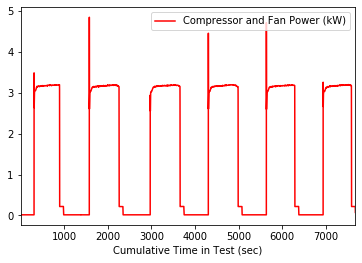

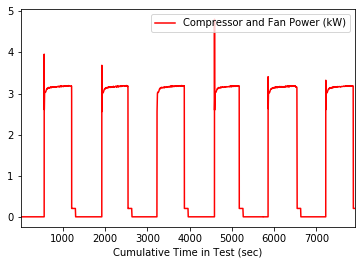

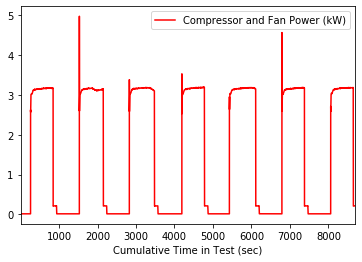

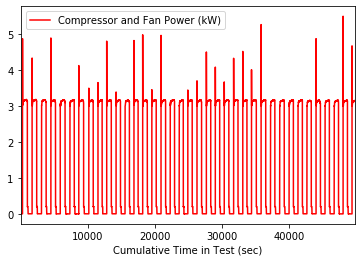

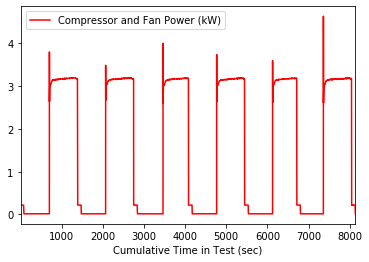

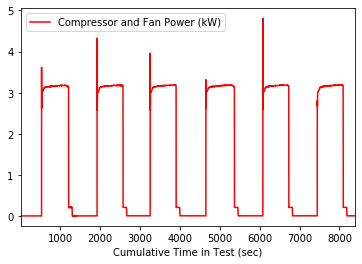

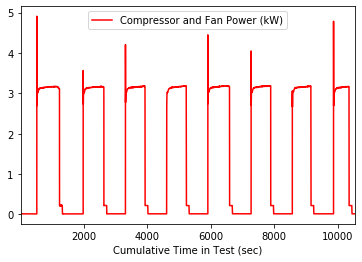

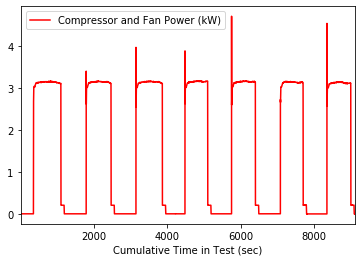

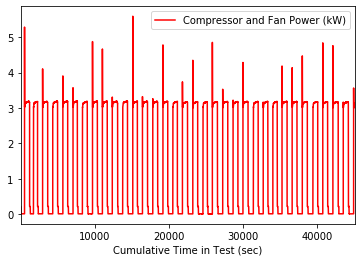

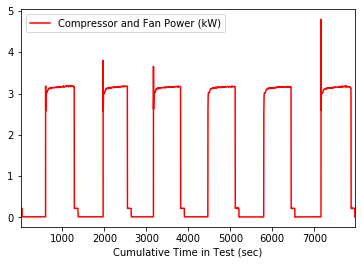

In [25]:
heating_group.plot(x='Cumulative Time in Test (sec)', y='Compressor and Fan Power (kW)', color='red', legend=Grouped_df['Filter ID'])
#plt.savefig("Images/Groupedby_HeatingandCooling_FilterID.png")
plt.show()


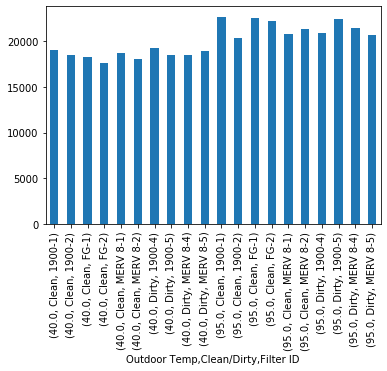

In [15]:
#graph Energy_Consumped_df results

Energy_Consumped_df['Compressor and Fan Energy (kWh)'].plot.bar()